In [9]:
!rm -rf wssv-recognition/ 
!git clone -b deep-learning-approach https://github.com/lorenzo-querol/wssv-recognition.git
!pip install -r /content/wssv-recognition/requirements.txt -q

Cloning into 'wssv-recognition'...
remote: Enumerating objects: 512, done.
remote: Counting objects: 100% (512/512), done.
remote: Compressing objects: 100% (452/452), done.
remote: Total 512 (delta 89), reused 477 (delta 54), pack-reused 0
Receiving objects: 100% (512/512), 33.46 MiB | 32.05 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import pathlib
import wandb
from wandb.keras import WandbCallback

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
!python3 /content/wssv-recognition/augment.py --data-dir /content/wssv-recognition/dataset --dest-dir /content/augmented_dataset

In [13]:
wandb.login()

wandb: Currently logged in as: renzo_querol. Use `wandb login --relogin` to force relogin


True

In [22]:
DATA_DIR = pathlib.Path("augmented_dataset")
AUTOTUNE = tf.data.AUTOTUNE

CONFIG = dict(
    epochs=500,
    learning_rate=1e-6,
    batch_size=32,
    img_shape=(224, 224),
    input_shape=(224, 224, 3),
    num_classes=2,
    dropout_rate=0.3,
    es_patience=40,
    valid_split=0.4,
    seed_value=42,
)

wandb.init(
    project="wssv-recognition",
    config=CONFIG,
    group="MobileNetV3Small",
    job_type="train",
)

In [23]:
image_count = len(list(DATA_DIR.glob("*/*.jpg")))
healthy_count = len(list(DATA_DIR.glob("healthy/*.jpg")))
wssv_count = len(list(DATA_DIR.glob("wssv/*.jpg")))

print(f"Total number of images: {image_count}")
print(f"Healthy: {healthy_count}")
print(f"WSSV: {wssv_count}\n")

train_set, valid_set = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=CONFIG["valid_split"],
    seed=CONFIG["seed_value"],
    image_size=CONFIG["img_shape"],
    batch_size=CONFIG["batch_size"],
    interpolation="bicubic",
    label_mode="binary",
    subset="both",
)

class_names = train_set.class_names
print(f"\nClass names: {class_names}")

Total number of images: 930
Healthy: 702
WSSV: 228

Found 930 files belonging to 2 classes.
Using 558 files for training.
Using 372 files for validation.

Class names: ['healthy', 'wssv']


In [24]:
validation_batches = tf.data.experimental.cardinality(valid_set)
test_dataset = valid_set.take(validation_batches // 5)
validation_dataset = valid_set.skip(validation_batches // 5)

train_dataset = train_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(
    f"\nNumber of training batches: {tf.data.experimental.cardinality(train_dataset)}"
)
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))


Number of training batches: 18
Number of validation batches: 10
Number of test batches: 2


In [25]:
"""
CREATE MODEL HERE
"""
def create_model():
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=CONFIG["input_shape"],
        include_top=False,
    )

    inputs = tf.keras.Input(shape=CONFIG["input_shape"])
    x = base_model(inputs, training=False) 
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=CONFIG["dropout_rate"], seed=CONFIG["seed_value"])(x)
    outputs = tf.keras.layers.Dense(units=1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="acc"),
            tf.keras.metrics.Precision(thresholds=0, name="prec"),
            tf.keras.metrics.Recall(thresholds=0, name="recall"),
            tfa.metrics.F1Score(
                num_classes=1, average="weighted", name="f1_score", threshold=0.5
            ),
            tf.keras.metrics.FalseNegatives(name="false_neg"),
        ],
    )

    return model

In [26]:
class_0_weight = (1 / healthy_count) * (image_count / 2.0)
class_1_weight = (1 / wssv_count) * (image_count / 2.0)
class_weight = {0: class_0_weight, 1: class_1_weight}

history = model.fit(
    train_dataset,
    epochs=CONFIG["epochs"],
    validation_data=validation_dataset,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=CONFIG["es_patience"]),
        tf.keras.callbacks.ModelCheckpoint(
            filepath="checkpoints/cp-{epoch:04d}.ckpt",
            save_weights_only=True,
            monitor='val_f1_score',
            mode='max',
            verbose=1,
            save_best_only=True
        ),
        WandbCallback(save_model=False),
    ],
)

Epoch 1/500
17/18 [===========================>..] - ETA: 0s - loss: 0.7949 - acc: 0.6949 - prec: 0.2625 - recall: 0.3443 - f1_score: 0.1616 - false_neg: 106.0000
Epoch 1: val_f1_score improved from -inf to 0.12121, saving model to checkpoints/cp-0001.ckpt
18/18 [==============================] - 10s 182ms/step - loss: 0.7896 - acc: 0.6971 - prec: 0.2699 - recall: 0.3520 - f1_score: 0.1592 - false_neg: 109.0000 - val_loss: 0.6499 - val_acc: 0.7175 - val_prec: 0.3571 - val_recall: 0.2410 - val_f1_score: 0.1212 - val_false_neg: 77.0000
Epoch 2/500
17/18 [===========================>..] - ETA: 0s - loss: 0.8124 - acc: 0.6967 - prec: 0.2105 - recall: 0.2667 - f1_score: 0.1709 - false_neg: 103.0000
Epoch 2: val_f1_score did not improve from 0.12121
18/18 [==============================] - 2s 94ms/step - loss: 0.8243 - acc: 0.6900 - prec: 0.2051 - recall: 0.2560 - f1_score: 0.1643 - false_neg: 108.0000 - val_loss: 0.6477 - val_acc: 0.7175 - val_prec: 0.3509 - val_recall: 0.2410 - val_f1_scor

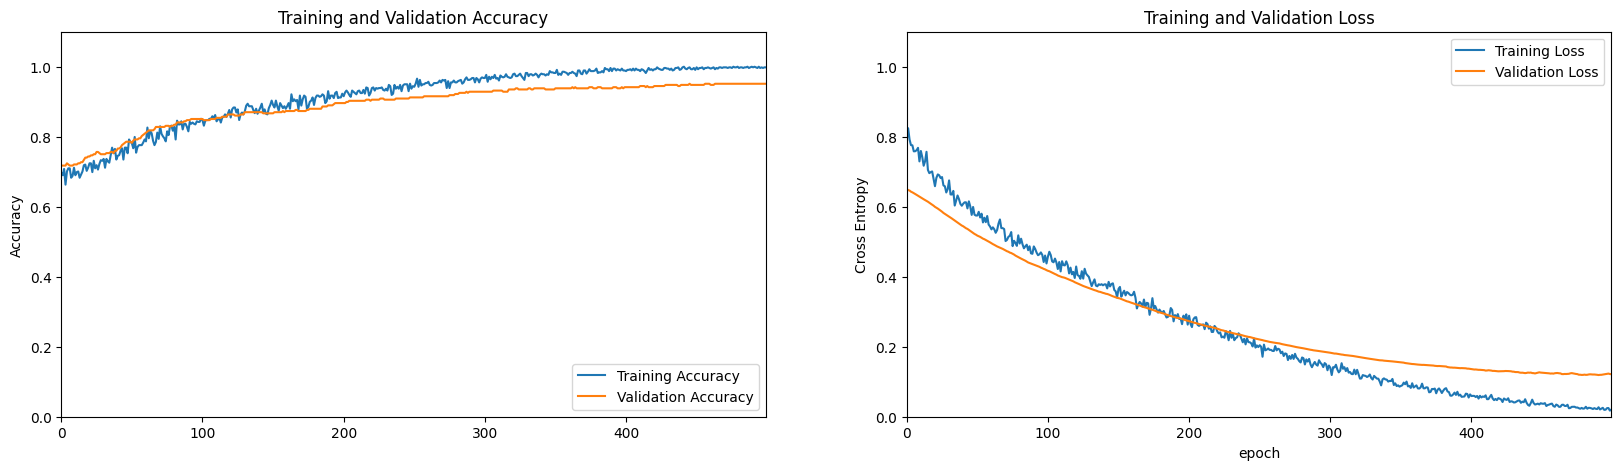

In [27]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

prec = history.history["prec"]
val_prec = history.history["val_prec"]

recall = history.history["recall"]
val_recall = history.history["val_recall"]

f1_score = history.history["f1_score"]
val_f1_score = history.history["val_f1_score"]

false_neg = history.history["false_neg"]
val_false_neg = history.history["val_false_neg"]


plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

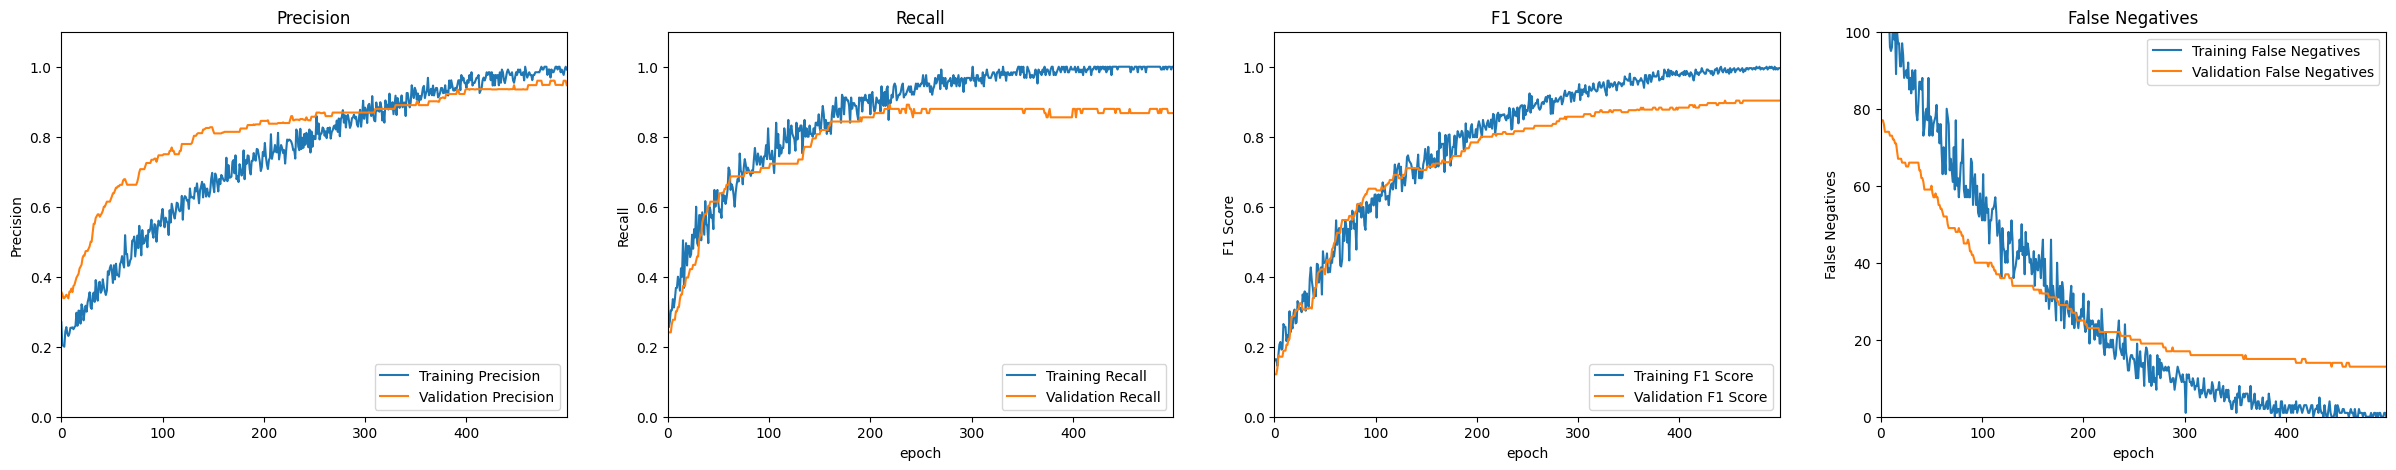

In [28]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 4, 1)
plt.plot(prec, label="Training Precision")
plt.plot(val_prec, label="Validation Precision")
plt.legend(loc="lower right")
plt.ylabel("Precision")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Precision")

plt.subplot(1, 4, 2)
plt.plot(recall, label="Training Recall")
plt.plot(val_recall, label="Validation Recall")
plt.legend(loc="lower right")
plt.ylabel("Recall")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Recall")
plt.xlabel("epoch")

plt.subplot(1, 4, 3)
plt.plot(f1_score, label="Training F1 Score")
plt.plot(val_f1_score, label="Validation F1 Score")
plt.legend(loc="lower right")
plt.ylabel("F1 Score")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("F1 Score")
plt.xlabel("epoch")

plt.subplot(1, 4, 4)
plt.plot(false_neg, label="Training False Negatives")
plt.plot(val_false_neg, label="Validation False Negatives")
plt.legend(loc="upper right")
plt.ylabel("False Negatives")
plt.ylim([0, 100])
plt.xlim([0, history.epoch[-1]])
plt.title("False Negatives")
plt.xlabel("epoch")

plt.show()

In [29]:
wandb.finish()

acc,▁▂▂▂▃▄▄▅▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇█▇▇█████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▂▂▃▃▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████████
false_neg,█▇▇▇▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
prec,▁▂▂▂▃▄▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████████
recall,▁▃▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████████████████
val_acc,▁▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████
val_f1_score,▁▂▃▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████
val_false_neg,█▇▇▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
